# Final Project: Competitive Euclidean Travelling Salesman Problem
### Gus Morris: 30524526


### Section 1: Specification Table
| <span style="font-weight:bold">Base Model</span>    | <span style="font-weight:normal"> A competitive multiple agent Travelling Saleperson model, introducing bonuses for agents who visits cities first among their peers</span>  |
| -------- | ------- |
| <span style="font-weight:bold">Extension Assumptions</span>   |  Relaxed condition for returning to original city as randomness of starting location might lead to advatageous situations for differing agents. In the new model cannot choose the original starting location but is instead randomly selected   |
| <span style="font-weight:bold">Techniques Showcased</span>  | Game Theory: Multiple agents compete against each other choosing which cities to visit next as a means of maximizing score <br><br> Monte Carlo Simulation: With the introduction of random starting points and different starting points for agents as well as a variety of game boards, simulate for different scenarios to analyze differing stratergies <br><br> Heuristics: Following the simulation of a game, use heuristics to simulate an optimal stratergy for additional agent amongst and already completed game board     |
| <span style="font-weight:bold">Modelling question 1</span>     | How does the introduction of multiple salesman affect travel paths and what equilibriums exist |
| <span style="font-weight:bold">Modelling question 2</span>     | Does an optimal stratergy arise over multiple iterations and differing circumstances and how useful is using heuristics in finding an optimal stratergy    |

In [87]:
from ctsp_algorithms import RN, NN, AG, AGP1
from main import Game
from genetic_algorithm import genetic_algorithm, compute_visited_iter
from plotTSP import plotTSP
from scipy.spatial import distance
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Section 2: Introduction

The Travelling Salesman Problem (TSP) is a fundamental optimization challenge where a salesman must visit a set of cities exactly once and return to the starting point, aiming to minimize the total travel distance. In the Euclidean variant, cities are positioned on a 2D plane, and distances are calculated using the Euclidean formula.

This project extends the traditional Euclidean TSP by introducing multiple competing agents instead of a single salesman. Each agent navigates the cities independently, aiming to optimize their path while considering interactions with other agents. This extension reflects scenarios where multiple entities compete for resources or navigate shared environments.

The key objectives of this extension are:

- Impact of Multiple Agents: Assess how the presence of multiple agents influences optimal pathfinding compared to a single-agent scenario.

- Strategy Evaluation: Determine which strategies, such as Random Neighbour (RN), Nearest Neighbour (NN), Aggressive (AG), and Aggressive + 1 (AGP1), yield the most efficient routes in a multi-agent setting.

- Equilibrium Analysis: Identify potential equilibrium states where agents’ strategies stabilize, and analyze their characteristics.

To explore these questions, Monte Carlo simulations are used to evaluate strategy performance across various scenarios. Additionally, a genetic algorithm is employed to find optimal strategies under the extended model, leveraging its ability to navigate complex solution spaces effectively.


### Section 3: Model Description

The Euclidean Travelling Saleman Problem is an optimization problem with the objective to determine the shortest path of a travelling saleman. We have several assumptions for our original model. Our agent visits N different citites exactly once. The problem is Euclidean in the sense that the cities are restricted to the euclidean (x,y)-plane and the distances where Euclidean distance $ d $ between two points $ ((x_1, y_1)) $ and $ ((x_2, y_2)) $ is given by:

$$  d = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}  $$

The implication of the euclidean distance property of the model is that all distances between cities are strictly non-negative under the assumption that no two cities can exist in the same location.In the original model, there is an assumption that the agent must return to the original city and therefore in conjunction of having to vist each city once, implies that the solution is a hamiltonian cycle.

Denoting the cities $ C $ where $ C_i \in C $ s.t $ i=1,...,N$ the cost of tour of a certain ETCP for some city permutation: $ C_{\sigma(0)}, C_{\sigma(1)}, ... , C_{\sigma(N)} $ is:

$$ {Cost} = \sum_{i=1}^{N-1} \sqrt{(x_{\sigma(i+1)} - x_{\sigma(i)})^2 + (y_{\sigma(i+1)} - y_{\sigma(i)})^2} + \sqrt{(x_{\sigma(1)} - x_{\sigma(N)})^2 + (y_{\sigma(1)} - y_{\sigma(N)})^2} $$

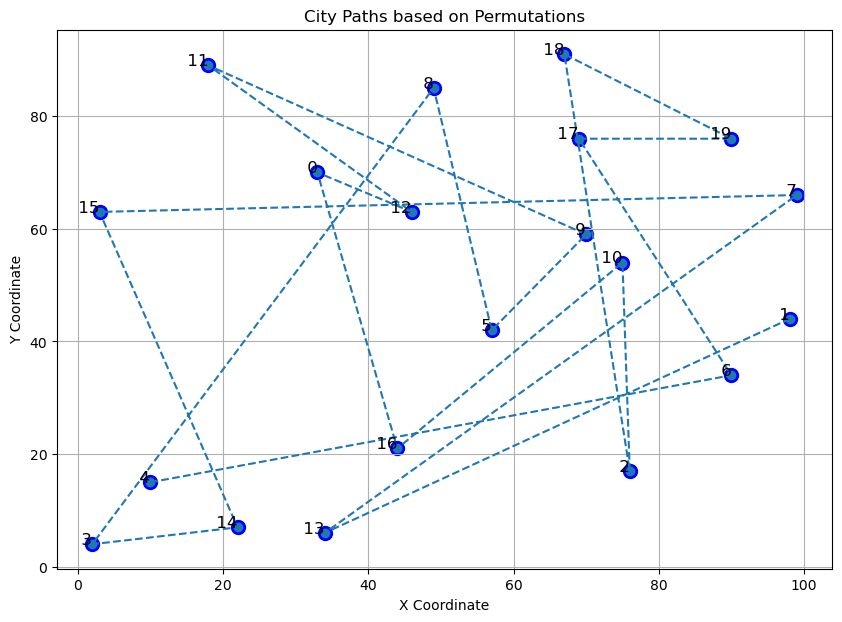

In [59]:
import matplotlib.pyplot as plt

colors = ['blue', 'orange', 'green', 'red', 'purple']

def plot_paths(cities, permutations):
    plt.figure(figsize=(10, 7))
    
    # Initialize city color mapping
    city_colors = [None] * len(cities)
    visit_times = [float('inf')] * len(cities)
    
    # Determine the first visit time for each city
    for color_idx, path in enumerate(permutations):
        for visit_time, city_idx in enumerate(path):
            city_idx = int(city_idx)
            if visit_times[city_idx] > visit_time:
                visit_times[city_idx] = visit_time
                city_colors[city_idx] = colors[color_idx]
            elif visit_times[city_idx] == visit_time:
                city_colors[city_idx] = 'black'
    
    # Plot the cities with appropriate colors
    for i, (x, y) in enumerate(cities):
        plt.scatter(x, y, color=city_colors[i], s=100)
        plt.text(x, y, f' {i}', fontsize=12, ha='right')

    # Plot each permutation as a separate path with dashed lines
    for path in permutations:
        int_path = [int(i) for i in path]  # Convert float indices to integers
        path_coords = [cities[i] for i in int_path]
        path_x, path_y = zip(*path_coords)
        plt.plot(path_x, path_y, marker='o', linestyle='--')

    # Add title and labels
    plt.title('City Paths based on Permutations')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()

def generate_tsp_instance(number_of_cities, grid_size):
    ans = []
    while len(ans) < number_of_cities:
        (x, y) = randint(0, grid_size, size=2)
        if (x, y) not in ans:
            ans.append((x, y))
    return ans

# Call the function to plot the paths
number_of_cities = 20
grid_size = 100

cities = generate_tsp_instance(number_of_cities, grid_size)
tour = np.random.permutation(number_of_cities)
tours = [tour]

plot_paths(cities, tours)

In this extension of the model, many of the same conditions apply except multiple competing agents exist on the board at the same time. Here we define $ s $ as the score of a move of a particular agent on the board at a given iteration. This score is the distance $ d $ defined in our original model plus some non-positive bonus value dependant on whether some agent $ i \in A $ arrives at a particular $ C_i \in C $ before any other agent, at the same time as any opposing agent $ j \in A $ or a turn after any $ j \in A $ where $ A $ defines the set of agents on the game board. We define sets  $V_k \subseteq C$ for those cities that have been visited at iteration $k$ of the game. With this we can define a function $ F(V_k, C_i) $ that determines the bonus for visiting a city at iteration $ k $ where $ b_0 < b_1 < b_2 \leq 0 $

$$

F(V_k, C_i) = \begin{dcases}
        b_0 & C_i \not\in V_k \\
        b_1 & C_i \isin V_k &\& & C_i \not\in V_{k-1} \\
        b_2 & C_i \isin V_k &\& & C_i \isin V_{k-1} \\
    \end{dcases}

$$

With this function an agents score can be easily computed by taking the original cost of our path for our original model and summing the bonuses via the previously defined function at each iteration. Note that we omit the final path back to original city. This is done so that there is not as much advantageous disparity between differing starting locations on the game board. It's important to now also note that solutions to the extended model are no longer hamiltonian circuits but instead hamiltonian paths.

$$ Score = \sum_{k=1}^{N-1} [\sqrt{(x_{\sigma(k+1)} - x_{\sigma(k)})^2 + (y_{\sigma(k+1)} - y_{\sigma(k)})^2} + F(V_k, C_{\sigma(k)})] $$

The original model of the Euclidean Travelling Saleman Problem was deterministic. No randomness existed in the original model and hence there existed a single optimal answer for a particular instance of a board. With the addition of random starting locations and differing stratergies in which agents make different decisions, the model becomes non-deterministic. If we are to further examine our model, it also becomes apparent that within our model there exist many different subgames occurring. If we are to take two distinct agents $ i,j \isin A $ and the distances $ d_{i,a}, d_{j,b} $ of each each agents from some arbitary cities $a,b$ to some unvisited $ x \isin C$ we can define the subgame for city $x$ at some iteration $k$:


|      | <span style="font-weight:bold">Visit</span>  | <span style="font-weight:bold">Don't Visit</span>  |
| :---:        |    :----:   |          :---: |
| <span style="font-weight:bold">Visit</span>          | $ (d_{i,a \rightarrow x} + b_1), (d_{j,b \rightarrow x} + b_1) $   | $ (d_{i,a \rightarrow w} + b_2), (d_{j,b \rightarrow x} + b_0) $ |
| <span style="font-weight:bold">Don't Visit</span>    | $ (d_{i,a \rightarrow x} + b_0), (d_{j,b \rightarrow u} + b_2) $   | $ (d_{i,a \rightarrow w} + 0), (d_{j,b \rightarrow u} + 0) $ |

The way we can intepret this table is that if two agents arrive at city $x$ at the same time they recieve the middle bonus $ b_1 $ plus eaches distance from the city, whereas if one of the agents takes a different route while the other arrives at $x$ at that iteration, it will be benefited with the highest bonus and the distance to the city while the last option is both going to different cities with no bonus for this city (however going to a different city would produce it's own subgame unto itself). With this subgame in mind we can now describe the implementation of four distinct stratergies used in the extended model.

### Stratergies:

| <span style="font-weight:bold"> Random Neighbour(RN)</span>    | <span style="font-weight:normal"> At each iteration agent choose random location based on non-visited cities</span>  |
| -------- | ------- |
| <span style="font-weight:bold">Nearest Neighbour(NN)</span>   |  Agent chooses next city based on the shortest distance from city currently residing at  |
| <span style="font-weight:bold">Aggressive(AG)</span>  | Agent chooses next location by first identifying non-visited cities and then choosing it's nearest neighbour from those non-visited cities  |
| <span style="font-weight:bold">Aggressive + 1 (AGP1)</span>     | Agent chooses city based on those not-visited and then choosing a city that will not be visited by another agent under the assumption that they are using NN stratergy |

With this addition we seek to answer the question of how the addition of multiple agents with differing stratergies affects the paths of our model and whether we can find any equilibriums that may arise in our model. As the model is now non-deterministic we employ the method of Monte Carlo Simulation in order to properly analyze the model. As well as analyzing the model via Monte Carlo Simulation we seek to find an optimal stratergy under which we can minimize our score as much as possible. Under the assumptions described, the original model lends well to an heauristic approach to finding an optimal solution. Under the revised assumptions of the extensions this still applies. However the added conditions of the extended model means that other factors must be considered such as the paths of the agents travel and how that affects the score. 

The means by which we will look for an optimal stratergy heuristically is by using the genetic algorithm on a completed instance of the extended model keeping in mind the additional constraints imposed by the new model. On completion of genetic algorithm analysis will be done on the solution to find any patterns that might elucidate a potential dominant stratergy

### Section 3: Results

Below is a typical game board in which our agents will play the Competitive Travelling Saleman game. The way in which to read this graph is that any agent that visits the node first will have the city highlighted in their particular colour. If a city is contested in that 2 agents arrive at it at the same time before any other agent, then the city will be highlighted black

Starting next round...


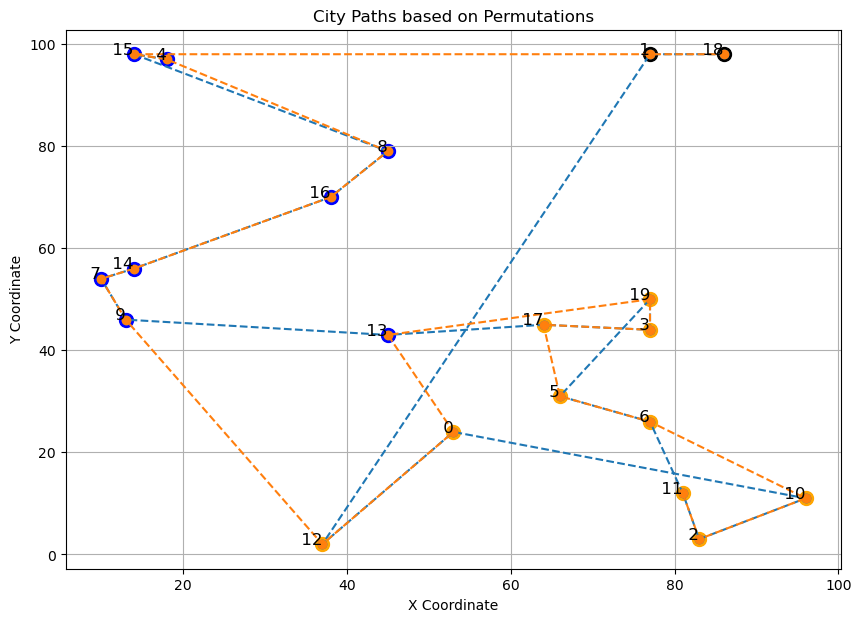

In [60]:
number_of_cities = 20
grid_size = 100
game = Game(number_of_cities, 2, grid_size)
game.simulate([NN, AG])
tours = game.path

plot_paths(game.cities, tours)

### Monte Carlo Simulation and Moving Mean Analysis

For the Monte Carlo Simulation, each stratergy played 1000 different instances of the game, for which each game was varied in the location of the cities. Each games head-to-head result were then tallied against each other and the moving mean over the entire array at each index. From here the result for each stratergy were collapsed onto top of each other to give a moving mean of each stratergies score at round i. The results of this were graphed to see if dominant stratergies emerged from the Monte Carlo Simulation.

All games simulated using the bonus tuple: $$ b = (-100, -50, 0) $$ 

In [ ]:
x = np.linspace(1, 1000, num=1000)
number_of_cities = 20
grid_size = 100
stratergies = [RN, NN, AG, AGP1]

vs_scores = np.zeros([20, 1000])

for k in range(1000):
    game = Game(number_of_cities, 2, grid_size)
    index = 0
    for i in range(len(stratergies)):
        for j in range(i, len(stratergies)):
            score_card = game.simulate([stratergies[i], stratergies[j]])
            vs_scores[(index)*2: (index)*2 + 2, k] = np.reshape(score_card, (2))
            index += 1

RNxRN = vs_scores[0:2, :]
RNxNN = vs_scores[2:4, :]
RNxAG = vs_scores[4:6, :]
RNxAGP1 = vs_scores[6:8, :]
NNxNN = vs_scores[8:10, :]
NNxAG = vs_scores[10:12, :]
NNxAGP1 = vs_scores[12:14, :]
AGxAG = vs_scores[14:16, :]
AGxAGP1 = vs_scores[16:18, :]
AGP1xAGP1 = vs_scores[18:20, :]

moving_means = np.zeros([20, 1000])
for i in range(1000):
    moving_means[0:, i] = np.reshape(np.mean(vs_scores[:,0:i+1], axis=1), (20))

RN_moving_mean = np.mean(moving_means[[0,1,2,4,6],:], axis=0)
NN_moving_mean = np.mean(moving_means[[3,8,9,10,12],:], axis=0)
AG_moving_mean = np.mean(moving_means[[5,11,14,15,16],:], axis=0)
AGP1_moving_mean = np.mean(moving_means[[7,13,17,18,19],:], axis=0)

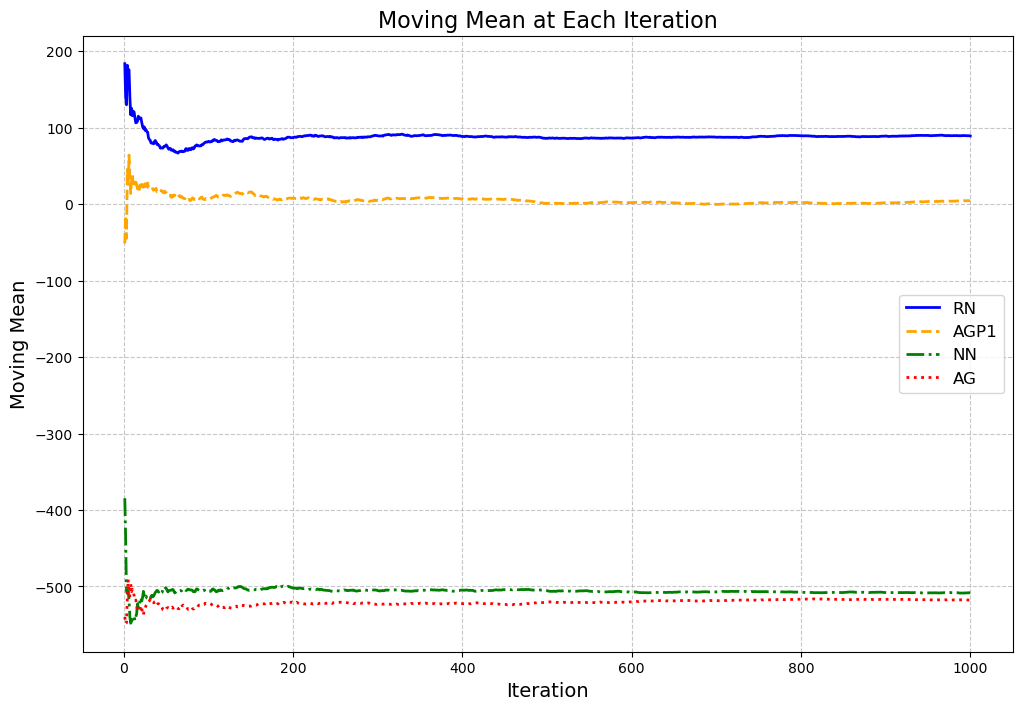

In [72]:
plt.figure(figsize=(12, 8))

# Plot each moving mean with different styles and labels
plt.plot(x, RN_moving_mean, label='RN', linestyle='-', color='blue', linewidth=2)
plt.plot(x, AGP1_moving_mean, label='AGP1', linestyle='--', color='orange', linewidth=2)
plt.plot(x, NN_moving_mean, label='NN', linestyle='-.', color='green', linewidth=2)
plt.plot(x, AG_moving_mean, label='AG', linestyle=':', color='red', linewidth=2)

# Add title and labels
plt.title('Moving Mean at Each Iteration', fontsize=16)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Moving Mean', fontsize=14)

# Customize the legend
plt.legend(fontsize=12, loc='best')

# Add a grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

From these graphs we can see that from our results that both the random choice and the aggressive plus one stratergy(in its current form) are non-satisfactory when compared to the agents employing the Nearest Neighbour(NN) and Aggressive(AG) stratergies. It's important to note that from these results the AGP1 stratergy performed deceptively bad and may be an issue concering the implementation of the algorithm and has not been fully investigated as a result of absense of time.

Due to this irregularity we will omit AGP1 from the rest of the analysis of the model.

Both stratergies AG and NN however appear to show similar results, which makes sense when we consider that they are similar stratergies, only differring with the AG's making decisions that place higher value on recieving bonuses. Further analysis should be performed with differeing bonuses to get any indication whether a dominant stratergy may arise with different bonus parameters.

We will keep the game board constant here, meaning the city locations will not change over the simulations, only the starting points of each agent and the bonuses in which they are awarded for reaching a city first

In [95]:
base_game = Game(number_of_cities, 2, 100)
base_bonus = (-100, -50, 0)
random_values = np.random.rand(1000)
scores = np.zeros([2, 1000])
stratergies = [NN, AG]


for index, weight in enumerate(random_values):
    base_game.bonus = (-50 * weight, -25 * weight, 0)
    score_card = base_game.simulate(stratergies)
    scores[:, index] = np.reshape(score_card, (2))

Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting next round...
Starting ne

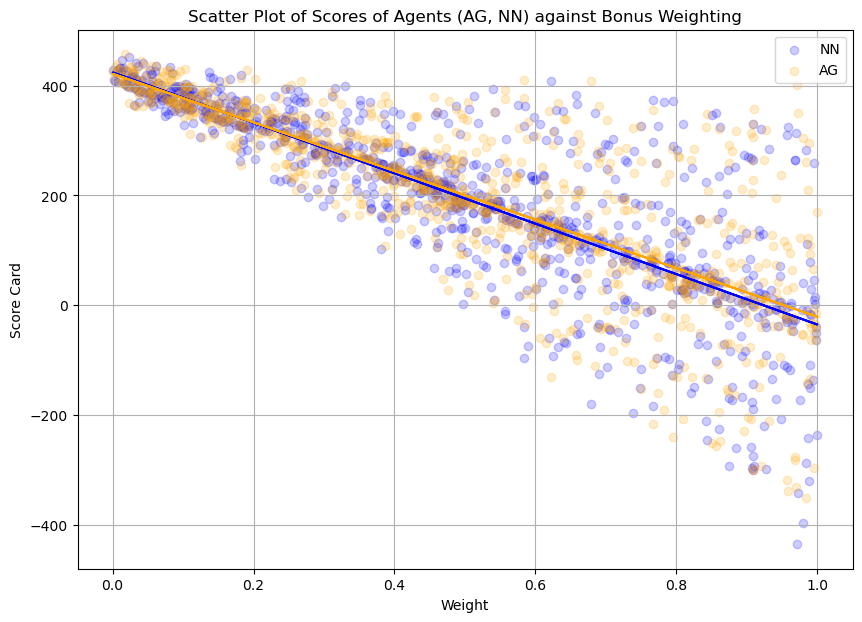

In [96]:
plt.figure(figsize=(10, 7))

# Scatter plot for the first set of y data
plt.scatter(random_values, scores[0, :], color='blue', label='NN', alpha=0.2)

# Calculate the line of best fit for the first set of y data
m1, b1 = np.polyfit(random_values, scores[0, :], 1)
plt.plot(random_values, m1 * random_values + b1, color='blue')

# Scatter plot for the second set of y data
plt.scatter(random_values, scores[1, :], color='orange', label='AG', alpha=0.2)

# Calculate the line of best fit for the second set of y data
m2, b2 = np.polyfit(random_values, scores[1, :], 1)
plt.plot(random_values, m2 * random_values + b2, color='orange')

# Add title and labels
plt.title('Scatter Plot of Scores of Agents (AG, NN) against Bonus Weighting')
plt.xlabel('Weight')
plt.ylabel('Score Card')
plt.legend()
plt.grid(True)
plt.show()

So as we take variation in weights of our bonus, it is still apparent that both stratergies bare relatively similar results. If anything of multiple tests it does appear that there does appear to be greater variation in scores as a result of higher values of bonuses being taken. This does make sense as we consider the scores may be greater in magnitude, and agents taking others bonuses has a large affect on overall score

### Heuristics in finding an Optimal Stratergy

A modified version of the genetic algorithm was used in computing an optimal solution to a game instance. For this the visited location had to be taken in mind, as we are considering this as an extra agent that has been added after the game has been played and know what decision each agent makes at each iteration.

As we must account for negative values with the addition of bonuses in our model, we must also change our selection criteria from the roulette wheel selection to rank based selection for our probabilities. This changes makes the negative values much easier to deal with

Starting next round...


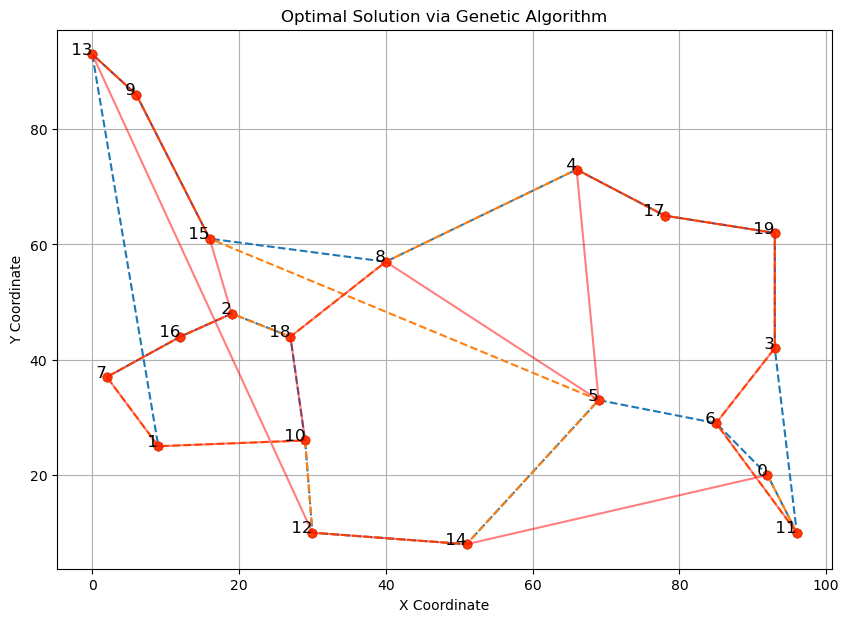

Optimal Cost Value=-693.0673235616829
Nearest Neighbour Cost Value=139.7144630077418
Aggressive Cost Value=272.85616936192906


In [101]:
base_game = Game(number_of_cities, 2, 100)
stratergies = [NN, AG]
scores_card = base_game.simulate(stratergies)

cities = base_game.cities
tours = base_game.path

visited_iter = compute_visited_iter(tours)
sol, cost_value = genetic_algorithm(cities, 50, 2000, 0.1, 0.1, visited_iter, base_game.bonus)

plt.figure(figsize=(10, 7))

# Plot the cities
x_coords, y_coords = zip(*cities)
plt.scatter(x_coords, y_coords, color='red')

# Annotate the cities with their indices
for i, (x, y) in enumerate(cities):
    plt.text(x, y, f' {i}', fontsize=12, ha='right')

# Plot each permutation as a separate path with dashed lines
for path in tours:
    int_path = [int(i) for i in path]  # Convert float indices to integers
    path_coords = [cities[i] for i in int_path]
    path_x, path_y = zip(*path_coords)
    plt.plot(path_x, path_y, marker='o', linestyle='--')

path_coords = [cities[i] for i in sol]
path_x, path_y = zip(*path_coords)
plt.plot(path_x, path_y, marker='o', color='red', alpha=0.5, label='Optimal')

# Add title and labels
plt.title('Optimal Solution via Genetic Algorithm')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()
print("Optimal Cost Value="+str(cost_value))
print("Nearest Neighbour Cost Value="+str(score_card[0]))
print("Aggressive Cost Value="+str(score_card[1]))

By simply examination of the path it can be seen that the optimal solutions incorporates elements that both AG and NN posess in that they seek to minimise distance, but has also placed more emphasis on going to unvisited cities.

From the analysis of the Heuristic optimal solution, an advantageous stratergy may involve using some heuristic approach in which it simulates a completed game board at each iteration based on the presumed stratergies of other agents based on their previous moves.

### Section 5: List of algorithms and concepts

- Competitive Travelling Saleperson Problem: Main Model for which we seek to gain results about
- Monte Carlo Simulation: Allows us to analyze and further understand or base model.
- Genetic Algorithm: Plays a part in helping us potentually find a winning stratergy